In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
from scipy.linalg import cholesky, cho_solve
from sklearn.linear_model.ridge import _solve_cholesky_kernel

import numpy as np
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
from kernellib.nystrom import RandomizedNystrom
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'kernellib.nystrom'

### Random Kitchen Sinks and Kernel Ridge Regression

Inspiration
* Original Paper at Berkeley - [Blog](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html)
* Randomized Kernels for Large Scale Earth Observation Applications - [ISP](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html)

In [44]:
class RKSKernelRidge(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=10, alpha=1e-3, gamma=1.0,
                 random_state=None):
        self.n_components = n_components
        self.alpha = alpha
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y):
        
        rng = np.random.RandomState(self.random_state)
        
        self.w = self.gamma * rng.randn(self.n_components, X.shape[1])
        self.Z = np.exp(1j * np.dot(X, self.w.T))
        
        K = np.dot(self.Z.T, self.Z) + alpha * np.eye(self.n_components)
        
        
        self.weights_ = np.linalg.solve(K, np.dot(self.Z.T, y))
        
        return self
    def transform(self, X):
        
        
        return np.exp(1j * np.dot(X, self.w.T))
    
    def predict(self, X):
        
        K_trans = np.exp(1j * np.dot(X, np.matrix.getH(self.w)))
        
        return np.real(np.dot(K_trans, self.weights_))
    def compute_kernel(self, X):
        
        L = self.transform(X)
        return np.dot(L, L.T)

## Random Kitchen Sinks

In [3]:
class RandomKitchenSinks(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=10, gamma=1.0,
                 random_state=None):
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X):
        
        rng = np.random.RandomState(self.random_state)
        
        self.w = self.gamma * rng.randn(self.n_components, X.shape[1])
        self.Z = np.exp(1j * np.dot(X, self.w.T))
        
        return self
    def transform(self, X):
        
        return np.exp(1j * np.dot(X, self.w.T))
    
    def compute_kernel(self, X):
        
        L = self.transform(X)
        return np.dot(L, L.T)

In [195]:
class RKSKernelRidge(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=10, alpha=1e-3, gamma=1.0,
                 random_state=None):
        self.n_components = n_components
        self.alpha = alpha
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y):
        
        rng = np.random.RandomState(self.random_state)
        
        self.rks = RandomKitchenSinks(
            n_components=self.n_components,
            gamma=self.gamma,
            random_state=self.random_state
        )
        self.rks.fit(X)
        self.L = self.rks.transform(X)
        
        K = np.dot(self.L.T, self.L) + alpha * np.eye(self.n_components)
        
        
        self.weights_ = np.linalg.solve(
            K, np.dot(self.L.T, y)
        )
        
        return self

    def predict(self, X):
        
        K_trans = self.rks.transform(X)
        
        return np.real(np.dot(K_trans, self.weights_))

In [196]:


rkskrr_model = RKSKernelRidge(n_components=n_components, 
                          alpha=alpha, 
                          gamma=gamma,
                          random_state=seed)
rkskrr_model.fit(xtrain, ytrain);
y_pred = rkskrr_model.predict(xtest)

In [197]:
%timeit rkskrr_model.fit(xtrain, ytrain)
%timeit rkskrr_model.predict(xtest)

71.8 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.13 ms ± 66.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.099952878719


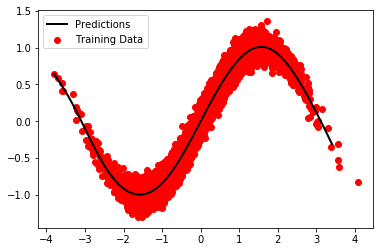

In [198]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rkskrr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

## Large Scale Kernel Ridge (General Approximation Schemes)

In [4]:
seed = 123
rng = np.random.RandomState(seed)
n_train, n_test = 10000, 1000
d_dimensions = 1
noise = 0.1

xtrain = rng.randn(n_train, d_dimensions)
ytrain = np.sin(xtrain) + noise * rng.randn(n_train, d_dimensions)

xtest = rng.randn(n_test, d_dimensions)
ytest = np.sin(xtest) + noise * rng.randn(n_test, d_dimensions)

# training
n_components = 10
alpha = 1e-3
gamma = 1.0

In [5]:
class KernelRidge(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=10, alpha=1e-3, gamma=1.0,
                 random_state=None, approximation='nystrom',
                 k_rank=10):
        self.n_components = n_components
        self.alpha = alpha
        self.gamma = gamma
        self.random_state = random_state
        self.approximation = approximation
        self.k_rank = k_rank
        
    def fit(self, X, y):
        
        rng = np.random.RandomState(self.random_state)
        
        # Do a kernel approximation
        self.L = self._kernel_approxmation(X)

        # Solve for weights
        K = np.dot(self.L.T, self.L)
        alpha = np.atleast_1d(self.alpha)
        
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
            ravel = True
        
        weights = _solve_cholesky_kernel(K, np.dot(self.L.T, y), alpha)
        self.weights_ = weights.ravel()
        
        return self
    def _kernel_approxmation(self, X):
        
        if self.approximation == 'rff':
            self.trans = RandomFourierFeatures(
                n_components=self.n_components, 
                gamma=self.gamma
            )
        elif self.approximation == 'rbfsampler':
            self.trans = RBFSampler(
                gamma=self.gamma,
                n_components=self.n_components, 
                random_state=self.random_state)
        elif self.approximation == 'nystrom':
            self.trans = Nystroem(
                kernel='rbf',
                gamma=self.gamma, 
                n_components=self.n_components
            )
        elif self.approximation == 'rnystrom':
            self.trans = RandomizedNystrom(
                kernel='rbf', sigma=self.gamma,
                n_components=self.n_components,
                k_rank=self.k_rank,
                random_state=self.random_state
            )
        else:
            raise ValueError('Unrecognized algorithm.')
            
        self.trans.fit(X)
        
        return self.trans.transform(X)
    
    def predict(self, X):
        
        K_trans = self.trans.transform(X)
        
        return np.real(np.dot(K_trans, self.weights_))

## Nystrom

In [6]:
from sklearn.kernel_approximation import Nystroem

In [7]:
approximation = 'nystrom'
krr_model = KernelRidge(n_components=n_components, 
                           alpha=alpha,
                           gamma=gamma,
                           random_state=seed, 
                        approximation=approximation)
krr_model.fit(xtrain, ytrain);
y_pred = krr_model.predict(xtest)

In [8]:
%timeit krr_model.fit(xtrain, ytrain)
%timeit krr_model.predict(xtest)

2.39 ms ± 52.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
292 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


29.0851376401


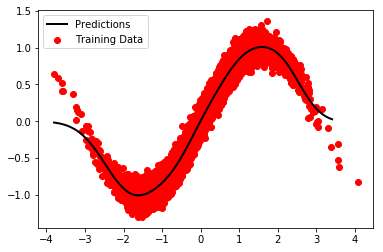

In [9]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = krr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

## Randomized Nystrom

In [10]:
from kernellib.nystrom import RandomizedNystrom

In [19]:
approximation = 'rnystrom'
krr_model = KernelRidge(n_components=n_components, 
                           alpha=alpha,
                           gamma=gamma,
                           random_state=seed, 
                        approximation=approximation, k_rank=10)
krr_model.fit(xtrain, ytrain);
y_pred = krr_model.predict(xtest)

In [20]:
%timeit krr_model.fit(xtrain, ytrain)
%timeit krr_model.predict(xtest)

2.93 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
288 µs ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


29.0807757025


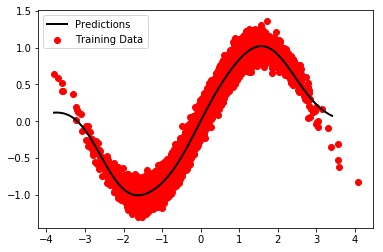

In [21]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = krr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

## RBF Sampler (Variation of Random Kitchen Sinks)

In [23]:
from sklearn.kernel_approximation import RBFSampler

In [24]:
approximation = 'rbfsampler'
krr_model = KernelRidge(n_components=n_components, 
                           alpha=alpha,
                           gamma=gamma,
                           random_state=seed,
                        approximation=approximation)
krr_model.fit(xtrain, ytrain);
y_pred = krr_model.predict(xtest)

In [25]:
%timeit krr_model.fit(xtrain, ytrain)
%timeit krr_model.predict(xtest)

1.94 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
190 µs ± 8.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


29.0937313862


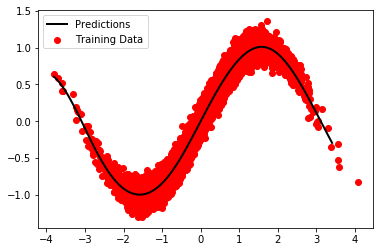

In [26]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = krr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

## Random Fourier Features

In [27]:
class RandomFourierFeatures(BaseEstimator):
    """Random Fourier Features """
    def __init__(self, n_components=50, gamma = 1.0,
                 random_state=None):
        self.gamma = gamma
        #Dimensionality D (number of MonteCarlo samples)
        self.n_components = n_components
        self.random_state = random_state
        self.fitted = False
        
    def fit(self, X, y=None):
        """ Generates MonteCarlo random samples """
        d = X.shape[1]
        
        rng = np.random.RandomState(self.random_state)
        #Generate D iid samples from p(w) 
        self.w = np.sqrt(2*self.gamma) * \
                 np.random.normal(size=(self.n_components,d))
        
        #Generate D iid samples from Uniform(0,2*pi) 
        self.u = 2*np.pi*np.random.rand(self.n_components)
        self.fitted = True
        return self
    
    def transform(self,X):
        """ Transforms the data X (n_samples, n_features) to the new map space Z(X) (n_samples, n_components)"""
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the feature map Z")
        #Compute feature map Z(x):
        Z = np.sqrt(2/self.n_components) * \
            np.cos((X.dot(self.w.T) + self.u[np.newaxis,:]))
        return Z
    
    def compute_kernel(self, X):
        """ Computes the approximated kernel matrix K """
        if not self.fitted:
            raise NotFittedError("RBF_MonteCarlo must be fitted beform computing the kernel matrix")
        Z = self.transform(X)
        return np.dot(Z, Z.T)

In [28]:
approximation = 'rff'
krr_model = KernelRidge(n_components=n_components, 
                           alpha=alpha,
                           gamma=gamma,
                           random_state=seed, 
                        approximation=approximation)
krr_model.fit(xtrain, ytrain);
y_pred = krr_model.predict(xtest)

In [29]:
%timeit krr_model.fit(xtrain, ytrain)
%timeit krr_model.predict(xtest)

7.38 ms ± 518 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
173 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


29.0872186726


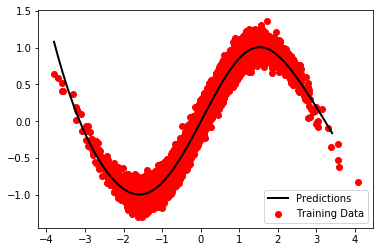

In [30]:


rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = krr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

## Random Kitchen Sinks

In [31]:
krr_model = RKSKernelRidge(n_components=n_components, 
                           alpha=alpha,
                           gamma=gamma,
                           random_state=seed)
krr_model.fit(xtrain, ytrain);
y_pred = krr_model.predict(xtest)

In [32]:
%timeit krr_model.fit(xtrain, ytrain)
%timeit krr_model.predict(xtest)

2.87 ms ± 77.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
235 µs ± 7.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.0999220720328


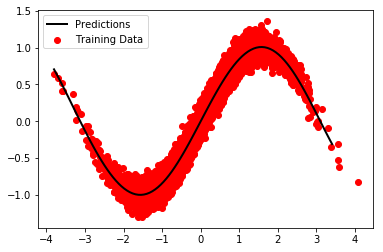

In [33]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print(rmse)

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = krr_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
plt.show()

# Simulation

Inspiration - [github](https://github.com/hichamjanati/srf/blob/master/RFF-I.ipynb)

In [34]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.datasets import make_low_rank_matrix 
import pandas as pd
import time

We would like to evaluate the kernel approximation quality by computing the MSE between the gram matrices:

$$\text{Mean Squared Error }(K, \tilde{K}) = \text{Mean }((K, \tilde{K})^2) $$

In this simulation well will be comparing the following algorithms:
* Nystrom Approximation 
* Randomized Nystrom Approximation
* Random Fourier Features (Exponential Projection)
* Random Fourier Features (Cosine Projection)

In [39]:
n_samples, d_dimensions = 8000, 100
effective_rank = 25
seed = 123

rng = np.random.RandomState(seed)
X = make_low_rank_matrix(n_samples=n_samples, n_features=d_dimensions,
                         effective_rank=effective_rank)

gamma = 2

# Number of features (Monte-Carlo samples) 
n_features = np.arange(1, 1000, 200)

K = rbf_kernel(X, gamma=gamma)
columns=['rff', 'nystrom', 'rnystrom', 'rks', 'sampler']
df_error = pd.DataFrame(columns=columns)
df_time = pd.DataFrame(columns=columns)

In [40]:
%%time

for ifeature in n_features:
    # -------------------------------------
    # Random Fourier Feature Approximation
    # -------------------------------------
    rff = RandomFourierFeatures(gamma=gamma, n_components=ifeature,
                                random_state=seed)
    
    t0_rff = time.time()
    
    rff.fit(X)
    K_approx = rff.compute_kernel(X)
    
    time_rff = time.time() - t0_rff
    
    err_rff = ((K_approx-K)**2).mean()
    
    # -----------------------------
    # Random Kitchen Sinks
    # -----------------------------
    rks = RandomKitchenSinks(gamma=gamma, n_components=ifeature, 
                            random_state=seed)
    
    t0_rks = time.time()
    
    rks.fit(X)
    K_approx = np.real(rks.compute_kernel(X))
    
    time_rks = time.time() - t0_rks
    err_rks = ((K_approx-K)**2).mean()
    
    # ----------------------
    # Nystrom Approximation
    # ----------------------
    nystrom = Nystroem(kernel='rbf', gamma=gamma, n_components=ifeature,
                       random_state=seed)
    
    t0_nys = time.time()
    
    nystrom.fit(X)
    L = nystrom.transform(X)
    K_approx = np.dot(L, L.T)
    time_nys = time.time() - t0_nys
    
    err_nys = ((K_approx-K)**2).mean()
    
    # ---------------------------------
    # Randomized Nystrom Approximation
    # ---------------------------------
    rnystrom = RandomizedNystrom(kernel='rbf', sigma=1/(2*np.sqrt(gamma)),
                                 n_components=n_components, 
                                 k_rank=50,
                                 random_state=seed)
    t0_rnys = time.time()
    
    rnystrom.fit(X)
    L = rnystrom.transform(X)
    K_approx = np.dot(L, L.T)
    time_rnys = time.time() - t0_rnys
    
    err_rnys = ((K_approx-K)**2).mean()
    # ------------
    # RBF Sampler
    # ------------
    rbf_sampler = RBFSampler(gamma=1.0, n_components=ifeature, 
                             random_state=seed)
    t0_samp = time.time()
    rbf_sampler.fit(X)
    L = rbf_sampler.transform(X)
    K_approx = np.dot(L, L.T)
    time_sampler = time.time() - t0_samp
    
    err_sampler = ((K_approx-K)**2).mean() 
    
    df2_error = pd.DataFrame({
        'rff': err_rff,
        'nystrom': err_nys,
        'rks': err_rks,
        'rnystrom': err_rnys,
        'sampler':err_sampler
    }, index=[ifeature])
    
    df2_time = pd.DataFrame({
        'rff': time_rff,
        'nystrom': time_nys,
        'rnystrom': time_rnys,
        'rks': time_rks,
        'sampler': time_sampler
    }, index=[ifeature])
    
    df_error = df_error.append(df2_error)
    df_time = df_time.append(df2_time)
    if ifeature % 10:
        print('Interation: {}'.format(ifeature))



Interation: 1
Interation: 201
Interation: 401
Interation: 601
Interation: 801
CPU times: user 47.9 s, sys: 11.7 s, total: 59.7 s
Wall time: 42.4 s


In [41]:
df_error.head()


,nystrom,rff,rks,rnystrom,sampler
1,1.603563e-04,0.416671,0.000830,0.000346,0.200678
201,2.770898e-10,0.018775,38707.631409,0.000346,0.002638
401,2.764051e-11,0.000761,154897.851264,0.000346,0.002133
601,1.152778e-11,0.000037,348533.042003,0.000346,0.000015
801,6.863050e-12,0.000103,619639.970572,0.000346,0.000521


In [42]:
df_time.head()

,nystrom,rff,rks,rnystrom,sampler
1,0.431144,0.361523,1.794837,0.581632,0.371082
201,0.783364,0.760442,1.652436,0.637096,0.721435
401,1.020236,0.940565,2.309070,0.569638,0.880584
601,1.301809,1.095354,3.139798,0.565889,1.058296
801,2.209406,1.296994,4.779951,0.665290,1.300549


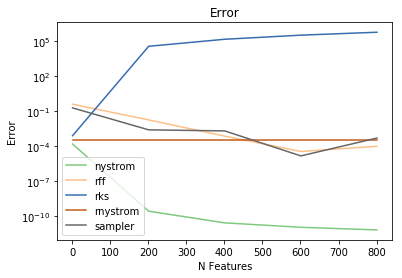

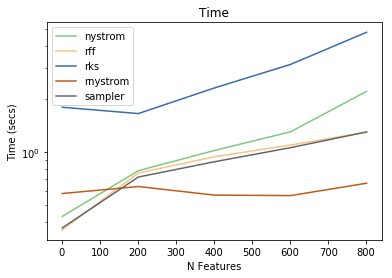

In [43]:
plt.figure();
ax1 = df_error.plot(logy=True, title='Error', colormap='Accent');
ax1.set_xlabel('N Features');
ax1.set_ylabel('Error');


plt.figure();
ax2 = df_time.plot(logy=True, title='Time', colormap='Accent');
ax2.set_xlabel('N Features');
ax2.set_ylabel('Time (secs)');

## Experimetn (Regression)

In [235]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
from matplotlib import pyplot as plt



## Load Data

In [238]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [239]:
digits = fetch_mldata('USPS')

HTTPError: HTTP Error 404: Dataset 'usps' not found on mldata.org.